In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from prophet import Prophet
import xgboost as xgb

plt.rcParams['figure.constrained_layout.use'] = True # 自动约束布局

In [421]:
df = pd.read_csv("data/data_preprocessed(新特征未归一化).csv", parse_dates=[0])

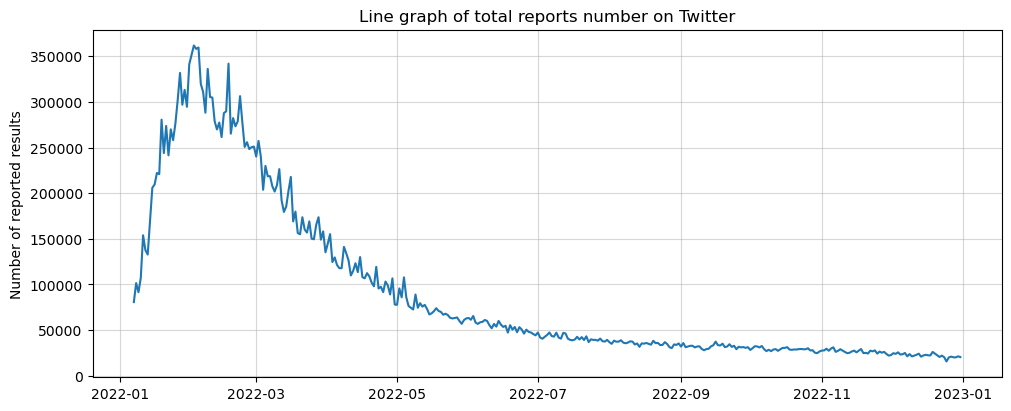

In [422]:
plt.figure(figsize=(10,4))

plt.plot(df['Date'], df['Number of  reported results'])

plt.ylabel('Number of reported results')
plt.title('Line graph of total reports number on Twitter')
plt.grid(True, alpha=0.5)

plt.savefig("figure/Line graph of total reports number on Twitter.png", dpi=250)
plt.show()

In [423]:
starttime = '2022-6'
endtime = '2023-03'

ts = df.loc[:,['Date', 'Number of  reported results']]
ts.columns = ['ds', 'y']
ts = ts[ts.ds >= starttime]
ts.reset_index(drop=True, inplace=True) # 重置索引
ts.head()

,ds,y
0,2022-06-01,63241
1,2022-06-02,61278
2,2022-06-03,65431
3,2022-06-04,58263
4,2022-06-05,56738


In [424]:
def func(x, a, b, c):
    return a*np.exp(-b*x)+c

popt, pcov = opt.curve_fit(func, xdata=ts.index, ydata=ts.y, bounds=(0, np.inf))
print("popt:", popt)
print("pocv:", pcov)

popt: [3.88995224e+04 1.30911060e-02 2.11967728e+04]
pocv: [[ 4.37808565e+05 -1.21130815e-01 -2.46428518e+05]
 [-1.21130815e-01  4.92466877e-07  4.42061838e-01]
 [-2.46428518e+05  4.42061838e-01  4.70322097e+05]]


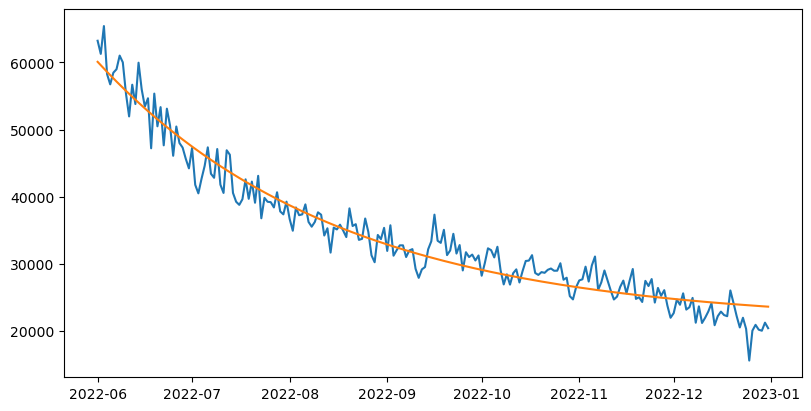

In [440]:
plt.figure(figsize=(8, 4))
plt.plot(ts.ds, ts.y)
plt.plot(ts.ds, func(ts.index, *popt))

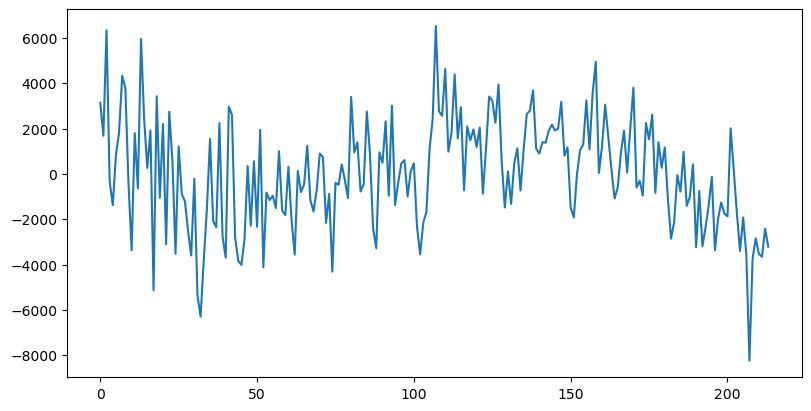

In [426]:
residual = ts.copy()
residual.y = ts.y - func(ts.index, *popt)

plt.figure(figsize=(8, 4))
plt.plot(residual.y)

In [427]:
m = Prophet(interval_width=0.95)
m.add_country_holidays(country_name='US')
m.fit(residual)

future = m.make_future_dataframe(periods=60)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

13:24:22 - cmdstanpy - INFO - Chain [1] start processing
13:24:22 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
269,2023-02-25,-1303.173759,-5756.956186,2746.922454
270,2023-02-26,-933.678787,-5258.645542,3341.223052
271,2023-02-27,-238.955303,-4624.830319,4288.808283
272,2023-02-28,54.096801,-4533.821698,4442.496849
273,2023-03-01,213.219734,-4277.405488,4624.695760


d:\CodingEnv\mambaforge\envs\prophet\Lib\site-packages\prophet\plot.py:92: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


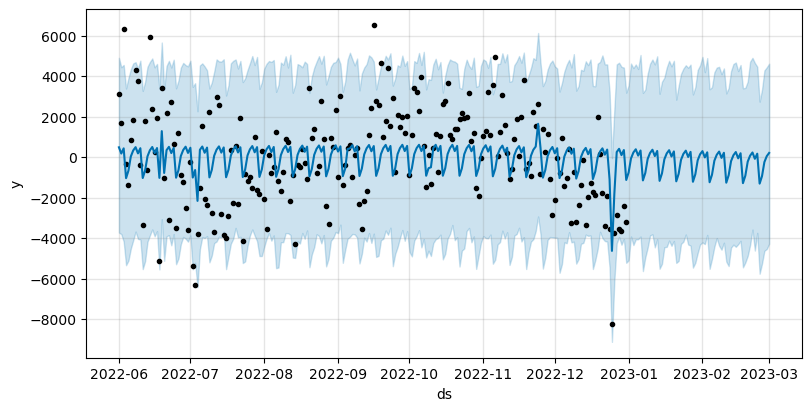

In [428]:
fig1 = m.plot(forecast, figsize=(8,4))

In [429]:
m_all = Prophet(interval_width=0.95)
m_all.add_country_holidays('US')
m_all.fit(ts)

13:24:23 - cmdstanpy - INFO - Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing


In [430]:
forecast_all = m_all.predict(future)

d:\CodingEnv\mambaforge\envs\prophet\Lib\site-packages\prophet\plot.py:194: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


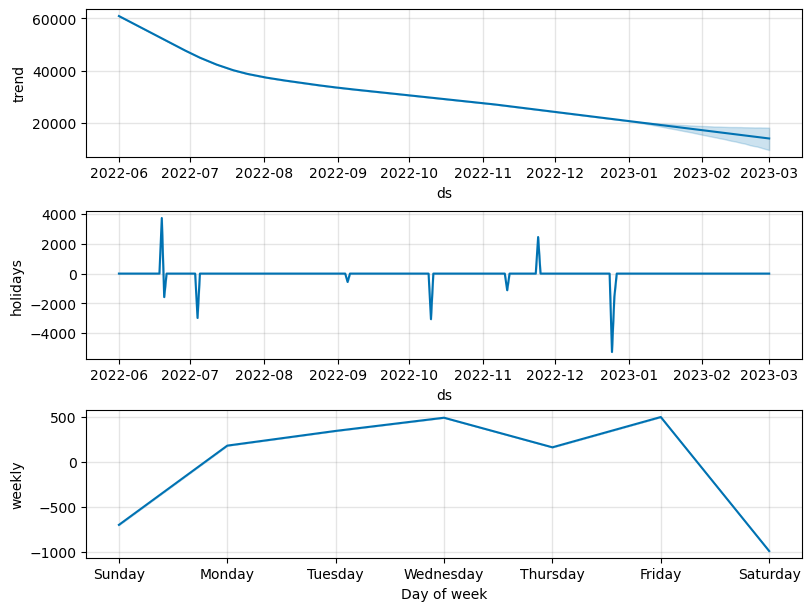

In [431]:
fig4 = m_all.plot_components(forecast_all, figsize=(8,6))

In [432]:
data_uptodate = pd.read_csv('data/data_uptodate.csv', index_col=0, parse_dates=[0])

[0]	validation_0-rmse:2126.55880
[1]	validation_0-rmse:2051.15159
[2]	validation_0-rmse:1982.34576
[3]	validation_0-rmse:1921.09676
[4]	validation_0-rmse:1866.96753
[5]	validation_0-rmse:1813.43709
[6]	validation_0-rmse:1766.73440
[7]	validation_0-rmse:1718.86917
[8]	validation_0-rmse:1678.11516
[9]	validation_0-rmse:1651.04247
[10]	validation_0-rmse:1620.61936
[11]	validation_0-rmse:1582.82626
[12]	validation_0-rmse:1556.45414
[13]	validation_0-rmse:1529.62936
[14]	validation_0-rmse:1502.50966
[15]	validation_0-rmse:1485.15447
[16]	validation_0-rmse:1466.96916
[17]	validation_0-rmse:1445.16094
[18]	validation_0-rmse:1434.26218
[19]	validation_0-rmse:1414.83224
[20]	validation_0-rmse:1401.85873
[21]	validation_0-rmse:1391.24463
[22]	validation_0-rmse:1373.35429
[23]	validation_0-rmse:1359.23438
[24]	validation_0-rmse:1349.87090
[25]	validation_0-rmse:1333.43821
[26]	validation_0-rmse:1321.82063
[27]	validation_0-rmse:1309.01011
[28]	validation_0-rmse:1298.64786
[29]	validation_0-rmse:1

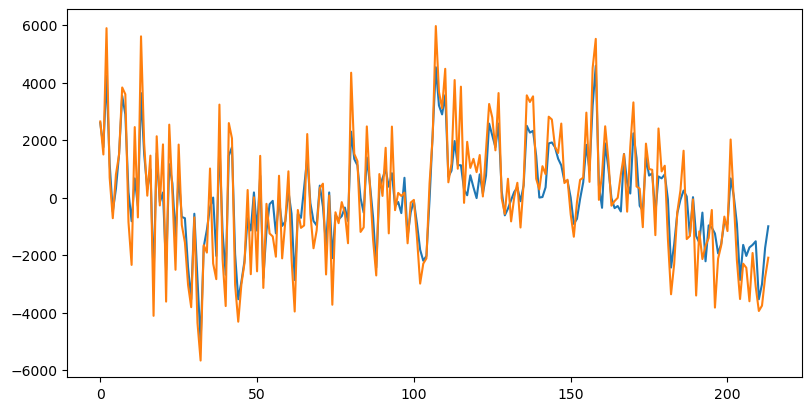

In [433]:
residual_train = ts.y.values - func(ts.index, *(popt)) - forecast.yhat[:ts.shape[0]]

model_X = xgb.XGBRegressor(n_estimators=90,
                        eta=0.1,
                        max_depth=6,
                        # colsample_bytree=0.6,
                        random_state=0,
                        early_stopping_rounds=50
                        )

model_X.fit(X=residual_train.shift(1).values.reshape(-1,1), y=residual_train.values,
        eval_set=[(residual_train.shift(1).values.reshape(-1,1), residual_train.values)],
        verbose=True) # Change verbose to True if you want to see it residual
forecast_X = model_X.predict(residual_train.shift(1).values.reshape(-1,1))

plt.figure(figsize=(8,4))
plt.plot(forecast_X)
plt.plot(residual_train)

In [434]:
# 滑动窗口创建预测值
res_x= [ts.y.values[-1]]
res_y = []

for i in range(60):
    new_res = model_X.predict(np.array(res_x[-1]).reshape(1,-1))[0]
    res_y.append(new_res)
    res_x.append(new_res)

residual_pred = res_y

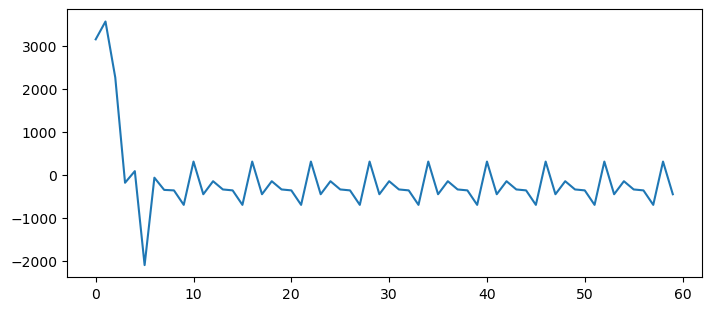

In [435]:
plt.figure(figsize=(7,3))
plt.plot(residual_pred)

In [436]:
y = func(future.index[-60:], *popt)
ylow = y + forecast.yhat_lower.iloc[-60:,].values + residual_pred
yupp = y + forecast.yhat_upper.iloc[-60:,].values + residual_pred

pred_all = pd.concat([func(ts.index, *popt)+forecast.yhat[:ts.shape[0]]+forecast_X, 
                        func(forecast.index[-60:], *popt)+forecast.yhat[-60:]+residual_pred])

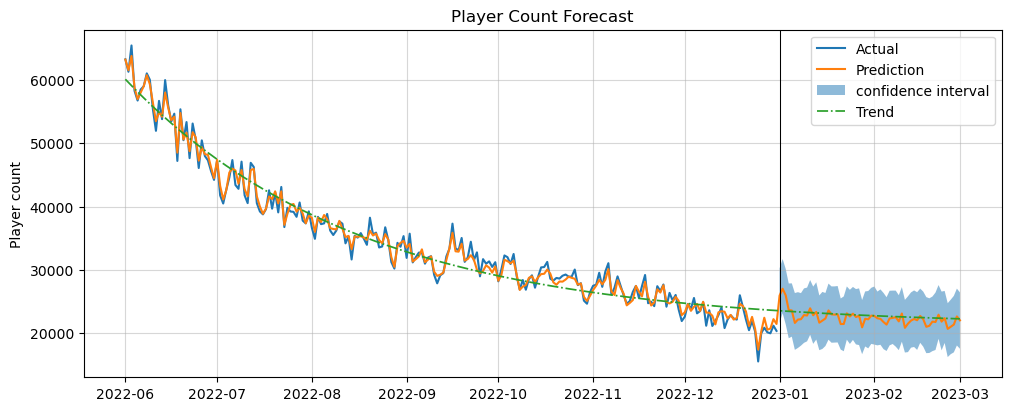

In [437]:
plt.figure(figsize=(10,4))
plt.plot(ts.ds, ts.y, label='Actual')
# plt.plot(ts.ds, func(ts.index, *popt)+forecast.yhat[:ts.shape[0]]+forecast_X, label='y_pred')
# plt.plot(future.ds[-60:], func(forecast.index[-60:], *popt)+forecast.yhat[-60:]+residual_pred)
plt.plot(future.ds, pred_all, label='Prediction')
plt.fill_between(future.ds[-60:], ylow, yupp, alpha=0.5,
                label='confidence interval')
plt.plot(future.ds, func(future.index, *(popt)), linestyle='-.', linewidth=1.25, label='Trend')

plt.axvline(x=pd.to_datetime('2023-01-01'), c='k', linewidth=0.75)
plt.grid(alpha=0.5)
plt.ylabel('Player count')
plt.title('Player Count Forecast')
plt.legend()

plt.savefig("figure/Player Count Forecast.svg")
plt.show()

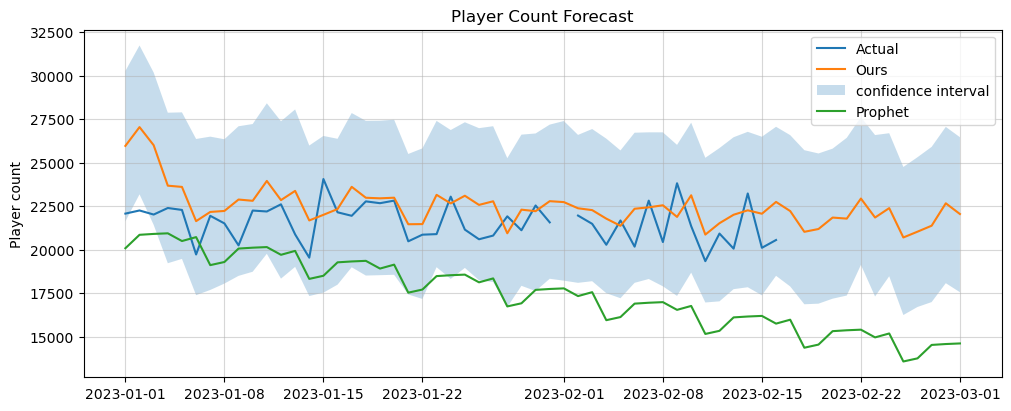

In [438]:
plt.figure(figsize=(10,4), layout='constrained')

plt.plot(data_uptodate, label='Actual')
plt.plot(future.ds[-60:], y+forecast.yhat[-60:]+residual_pred,label='Ours')
plt.fill_between(future.ds[-60:], ylow, yupp, alpha=0.25,
                label='confidence interval')
plt.plot(future.ds[-60:], forecast_all.yhat[-60:], label='Prophet')

plt.grid(alpha=0.5)
plt.ylabel('Player count')
plt.legend()
plt.title('Player Count Forecast')

plt.savefig('figure/Forecast Contrast.svg')
plt.show()

In [439]:
print(ylow[-1], yupp[-1])

17557.383750318106 26459.4849987306
